## Machine Learning Approach

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.pipeline import Pipeline
import pickle
from joblib import dump
%matplotlib inline

In [102]:
df = pd.read_csv(r'C:\Users\Dell\Kaggle notebooks\Fake News Detection\data.csv')
df.head()

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1
3,https://www.reuters.com/article/us-mexico-oil-...,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1


In [103]:
df_train = df.copy()

In [104]:
df.shape

(4009, 4)

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   URLs      4009 non-null   object
 1   Headline  4009 non-null   object
 2   Body      3988 non-null   object
 3   Label     4009 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 125.4+ KB


In [106]:
#removing missing values
df.dropna(axis = 0,inplace = True)

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3988 entries, 0 to 4008
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   URLs      3988 non-null   object
 1   Headline  3988 non-null   object
 2   Body      3988 non-null   object
 3   Label     3988 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 155.8+ KB


In [108]:
df.reset_index(inplace = True)

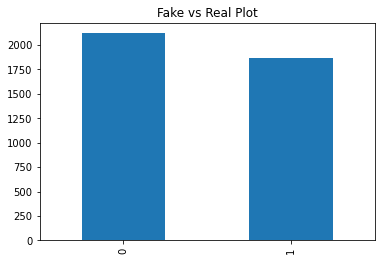

In [109]:
df.Label.value_counts().plot.bar()
plt.title('Fake vs Real Plot')
plt.show()

In [110]:
#considering only the headlines fro first model
def preprocess(text):
    ps = PorterStemmer()
    headline = re.sub('[^a-zA-Z]'," ",text)
    headline = headline.lower()
    headline = headline.split()
    headline = [ps.stem(word) for word in headline if not word in stopwords.words('english')]
    headline = " ".join(headline)
    return headline

In [111]:
corpus = []
for text in tqdm(df['Headline']):
    output = preprocess(text)
    corpus.append(output)
corpus[0:7]

100%|█████████████████████████████████████████████████████████████████████████████| 3988/3988 [00:11<00:00, 361.53it/s]


['four way bob corker skewer donald trump',
 'linklat war veteran comedi speak modern america say star',
 'trump fight corker jeopard legisl agenda',
 'egypt cheiron win tie pemex mexican onshor oil field',
 'jason aldean open snl vega tribut',
 'jetnat fanduel leagu week',
 'kansa tri tax plan similar trump fail']

In [112]:
len(corpus)

3988

In [113]:
tfidf = TfidfVectorizer(max_features = 6000,ngram_range = (1,3))

In [114]:
rf_pipeline = Pipeline([('tfidf',tfidf),('clf',RandomForestClassifier())])

In [115]:
y = df['Label'].values
X = np.array(corpus)
print(X.shape)
print(y.shape)

(3988,)
(3988,)


In [116]:
kf = StratifiedKFold(n_splits = 10)
i = 1
train_accuracy = []
val_accuracy = []
for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    #print(train_index,test_index)
    X_train,X_val = X[train_index],X[test_index]
    y_train,y_val = y[train_index],y[test_index]
    rf_pipeline.fit(X_train,y_train)
    y_pred_train = rf_pipeline.predict(X_train)
    y_pred = rf_pipeline.predict(X_val)
    print(f'Training accuracy is {accuracy_score(y_train,y_pred_train)}')
    print(f'Validation accuracy is {accuracy_score(y_val,y_pred)}')
    val_accuracy.append(accuracy_score(y_val,y_pred))
    train_accuracy.append(accuracy_score(y_train,y_pred_train))
    i += 1

1 of KFold 10
Training accuracy is 0.9986068542769574
Validation accuracy is 0.8596491228070176
2 of KFold 10
Training accuracy is 0.9988854834215659
Validation accuracy is 0.8646616541353384
3 of KFold 10
Training accuracy is 0.9991641125661744
Validation accuracy is 0.8771929824561403
4 of KFold 10
Training accuracy is 0.9988854834215659
Validation accuracy is 0.8521303258145363
5 of KFold 10
Training accuracy is 0.9991641125661744
Validation accuracy is 0.8345864661654135
6 of KFold 10
Training accuracy is 0.9988854834215659
Validation accuracy is 0.8596491228070176
7 of KFold 10
Training accuracy is 0.9991641125661744
Validation accuracy is 0.8270676691729323
8 of KFold 10
Training accuracy is 0.9986068542769574
Validation accuracy is 0.8796992481203008
9 of KFold 10
Training accuracy is 0.9988857938718663
Validation accuracy is 0.8844221105527639
10 of KFold 10
Training accuracy is 0.9991643454038998
Validation accuracy is 0.8291457286432161


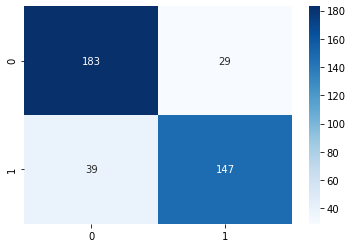

In [117]:
sns.heatmap(confusion_matrix(y_val,y_pred),annot = True,cmap = 'Blues',fmt = 'd')
plt.show()

In [118]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       212
           1       0.84      0.79      0.81       186

    accuracy                           0.83       398
   macro avg       0.83      0.83      0.83       398
weighted avg       0.83      0.83      0.83       398



In [119]:
filename = 'fake_news_detec_pipeline.pkl'
with open(filename,'wb') as file:
    pickle.dump(rf_pipeline,file)